In [5]:
import os
import tensorflow as tf
import TCC.models.unet as unet
from TCC.model_util import ImgTester, model_path
from TCC.model_util import Saver
from TCC.model_util import load_all_imgs

In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available 1


In [17]:
kernel_size=(3, 3)
padding="same"
strides=1
image_size = (256,256)
epochs = 30
batch_size= 8
validation_split= 0.2
f = [16, 32, 64, 128, 256]
threshold = 0.5
metric = tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=threshold
)
base_output_path = '..\\imagens_cra\\result\\unet_internal_default_epoch_'+str(epochs)+'_size_'+str(image_size)
x_dir = "../imagens_cra/train/cra"
y_dir = "../imagens_cra/validation_interna/cra"


In [8]:
# Load images
trainImgs = load_all_imgs(x_dir,image_size, 1)
validImgs = load_all_imgs(y_dir,image_size, 0)


../imagens_cra/train/cra found 659 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[200]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[300]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[400]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[500]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[600]:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
../imagens_cra/validation_interna/cra found 659 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

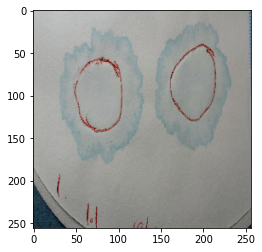

In [9]:
import matplotlib.pyplot as plt
plt.imshow(trainImgs[0])

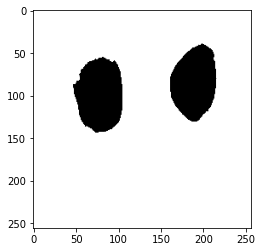

In [10]:
plt.imshow(validImgs[0], cmap=plt.cm.binary)

In [11]:
model = unet.build(image_size, f)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[metric])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [12]:
try:
    os.mkdir(base_output_path)
except OSError as error:
  pass

callbacks = tf.keras.callbacks.ModelCheckpoint(
    model_path(base_output_path),
    monitor='binary_accuracy', verbose=0,
    save_best_only=True,
    mode='auto',
    save_freq='epoch',
)
history = model.fit(
    trainImgs, validImgs,
    epochs=epochs,  batch_size=batch_size, callbacks=callbacks,
    validation_split=validation_split,
)

Epoch 1/30
66/66 [==============================] - 38s 353ms/step - loss: 0.4241 - binary_accuracy: 0.8703 - val_loss: 0.2853 - val_binary_accuracy: 0.8699

saved to: ..\imagens_cra\result\unet_default_epoch_30_size_(256, 256)\acc_por_epocas


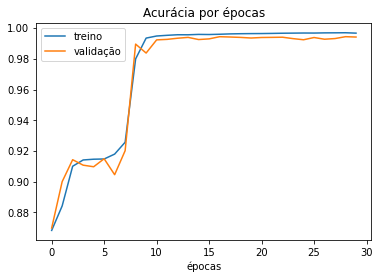

In [13]:
internal_saver = Saver(model, history, base_output_path)
internal_saver.save_metrics("binary_accuracy")

saved to: ..\imagens_cra\result\unet_default_epoch_30_size_(256, 256)\loss_por_epocas


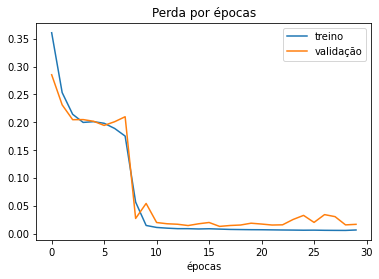

In [14]:
internal_saver.save_loss()

found 659 img to test

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[200]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[300]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[400]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[500]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[600]:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Write metrics to: ..\imagens_cra\result\unet_internal_default_epoch_30_size_(256, 256)\metrics.csv


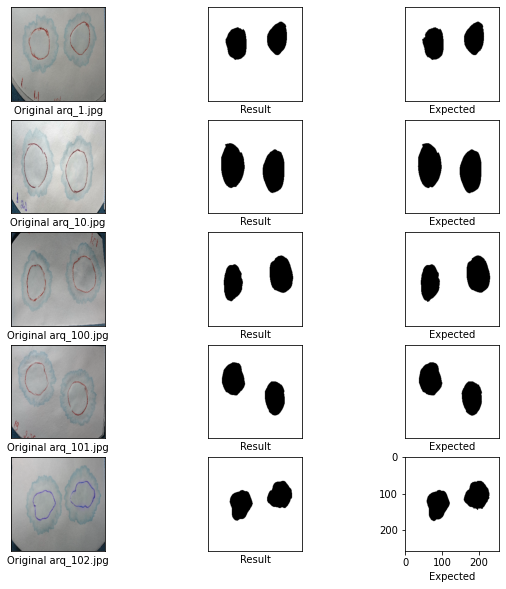

In [19]:
imgTester_metrics = [metric, tf.keras.metrics.MeanIoU(num_classes=2)]
imgTester = ImgTester(base_output_path, x_dir, y_dir, image_size)
imgTester.test(-1, 5, imgTester_metrics, threshold)
